In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy.sparse as sps

In [2]:
def SigmoidalBasis(A,b,x):
    n = len(A)
    phi = np.empty((n,len(x)))
    u = np.empty(len(x))
                   
    for k in range(n):
        u = A[k]*x+b[k]
        #phi[k] = 1/(1+np.exp(-u)) # Sigmoid activation function
        phi[k] = np.max(u,0)       # RelU activation function
                   
    return phi
    
# def SigmoidalBasisDerivative(A,b,x):
#     n = len(A)
#     Dphi = np.empty((n,len(x)))
#     u = np.empty(len(x))
                   
#     for k in range(n):
#         u = A[k]*x+b[k]
#         Dphi[k] = A[k]*np.exp(-u)/((1+np.exp(-u))**2)
                   
#     return Dphi    


We are going to solve the following 1-D OT problem


$$\text{Maximize} \int_0^1 \phi(x)dx + \int_0^1\psi(y)dy$$
$$\text{subject to } \quad\quad \phi(x)+\psi(y) \leq |x-y|^2 \;\forall\;x,y\in[0,1]$$

If $\phi_*,\psi_*$ are the optimizers for this problem, then the optimal transport map should be given by

$T(x) = y(x) \text{ s.t. } \phi_*(x)+\psi_*(y(x)) = |x-y(x)|^2$ $\Leftrightarrow$  $\nabla \phi_*(x) = 2(x-y(x))$ (this is because we have a critical point)

This tell us that 

$$T(x) = x- \frac{1}{2}\nabla \phi_*(x) = \nabla ( \frac{1}{2}|x|^2-\frac{1}{2}\phi_*(x))$$


We are going to take $k$ equally space points in $[0,1]$

In [18]:
k = 100
t = np.linspace(0,1,k)

# Sigmoidal basis (random inner weights):
n = 5
A = 10*(np.random.uniform(size=n)-0.5)
b = 10*(np.random.uniform(size=n)-0.5)

basis = SigmoidalBasis(A,b,t)
#Dbasis = SigmoidalBasisDerivative(A,b,t)

c = np.empty((k,k))

# Generates the k x k matrix of distances $|x_i-x_j|^2$
for i in range(k):
    for j in range(k):
        c[i,j] = (i-j)**2

cost = c/((k-1)**2)    

In [19]:
# Here is where CVX (CVXPY) comes in
# Setting up the particular problem

# We are declaring the variables (to be optimized) phi and psi
# which are here the vector of coefficients for the functions in the function basis
# "basis" from earlier

phi = cp.Variable(len(basis.T[0]))
psi = cp.Variable(len(basis.T[0]))

f = np.ones(k) # source density
g = np.ones(k) # target density

In [20]:
# Declare constraints
# This encodes the constraint that phi(x_i)+psi(y_j) <= c(x_i,x_j)
# as a matrix inequality
constraints = [cp.bmat(k*[basis.T @ phi]) + cp.bmat(k*[basis.T @ psi]).T  <= cost]

#constraints = [cp.outer(cp.exp(phi @ basis),cp.exp(psi @ basis)) <= cp.exp(cost)]

# declare we are maximizing sum of integrals of phi and psi, under the given constraints
prob = cp.Problem(cp.Maximize((basis.T @ phi) @ f + (basis.T @ psi) @ g), constraints)

prob.solve(verbose= False, solver = 'SCS')


-3.5356871855626165e-06

In [8]:
# Generating the arrays for
# |x|^2/2-\phi(x)/2 and
# |y|^2/2-\psi(y)/2

sol1 = (0.5)*(t**2)-(0.5)*(basis.T @ phi.value)
sol2 = (0.5)*(t**2)-(0.5)*(basis.T @ psi.value)


-9.238339730710532e-07
-9.238339730988088e-07


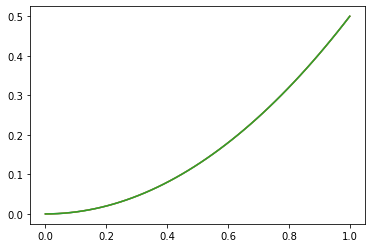

In [12]:
plt.plot(t,sol1)
plt.plot(t,sol2)
plt.plot(t,(0.5)*(t**2))
print(np.max(sol1-(0.5)*(t**2)))
print(np.min(sol1-(0.5)*(t**2)))

In [ ]:
x = np.array([1,0,1])
y = np.array([0,1,0])

M = cp.bmat(3*[x])
N = cp.bmat(3*[y]).T

In [ ]:
print(M.value)
print(N.value)

1. Extend this to more general source/target densities
2. Extend this to 2D problem (how to represent $\Omega$, $\bar \Omega$, $f$, $g$?)
3. Optimize the code so large values of n and k can be given

